# Comprehensive Signal Analysis: Time-Domain and Frequency-Domain Techniques for Signal Processing on netra_50msps.dat

In [1]:
import numpy as np
from numpy import sin, cos, pi
from scipy.fftpack import fft, fftfreq, ifft
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.fft import fft
from scipy.signal import spectrogram
import scipy.signal as signal
from scipy.signal.windows import hamming
from scipy.signal import resample  # Importing the resample function
import scipy.signal

print('Imported successfully')

Imported successfully


# ORIGINAL DATA

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


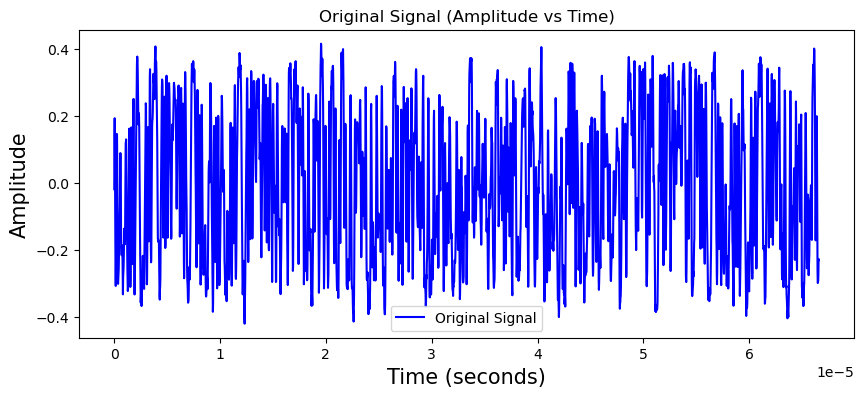

In [2]:
# Load the data from the .dat file
samplefile = "/home/sandeep/Downloads/netra_50msps.dat" # Corrected file pathsample_bbbs_assignment_id100.dat

# Step 1: Read the data
with open(samplefile, "rb") as f:
    netra_data = np.fromfile(f, dtype=np.complex64)


# Step 2: Define the sampling frequency (fs)
fs = sampling_rate= 50e6  # 50 million samples per second (50Msps) 
# Step 3: Create a time array in seconds
time = np.arange(0, len(netra_data)) / sampling_rate

# Step 4: Plot the Original Signal with Time on x-axis
plt.figure(figsize=(10, 4))
plt.plot(time, netra_data, label="Original Signal", color='blue')
plt.title("Original Signal (Amplitude vs Time)")
plt.xlabel("Time (seconds)",fontsize=15)
plt.ylabel("Amplitude",fontsize=15)
plt.legend()
plt.show()


# Spectrogram visualization of netra data

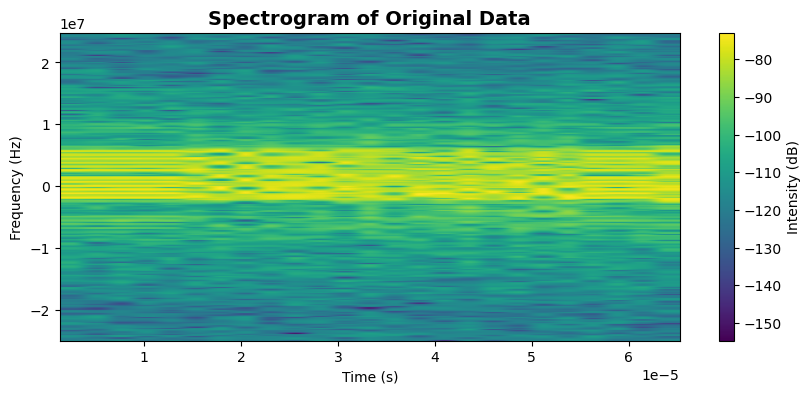

In [3]:
# Compute and plot spectrogram for the original data
plt.figure(figsize=(10, 4))
plt.specgram(netra_data, Fs=fs)
plt.title('Spectrogram of Original Data', fontsize=14, fontweight='bold')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Intensity (dB)")
plt.show()

In [5]:
# Calculate the number of samples in the signal
num_samples = len(netra_data)

# Calculate the duration of the signal (in seconds)
duration = num_samples / fs

# Print the results
print(f"Number of samples: {num_samples}")
print(f"Duration of the signal: {duration} seconds")


Number of samples: 3330
Duration of the signal: 6.66e-05 seconds


# Frequency spectrum of netra data

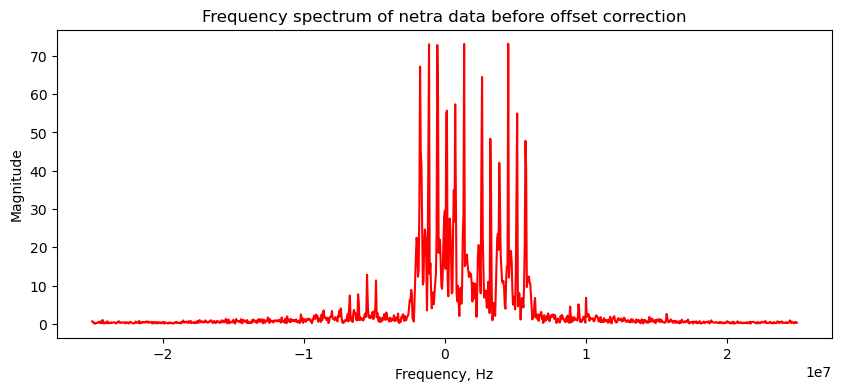

In [11]:
# Set fft size
N_fft = 1024

# calculate fft
netra_data_fft = np.fft.fftshift(np.fft.fft(netra_data, N_fft))
freqs = np.fft.fftshift(np.fft.fftfreq(N_fft,1/fs))


plt.figure(figsize=(10, 4))
plt.plot(freqs, np.abs(netra_data_fft),color='red')

plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum of netra data before offset correction')
plt.show()

# Estimate frequency offset of netra data

In [5]:
import numpy as np
from scipy.signal import welch, hamming

class DroneSignalProcessor:
    def __init__(self, debug=True):
        self.debug = debug

    @staticmethod
    def consecutive(data, stepsize=1):
        """Group consecutive elements based on a step size."""
        return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)

    def estimate_offset(self, y, Fs, packet_type="droneid"):
        """Estimate the frequency offset in the signal."""
        nfft_welch = 2048  # FFT size for PSD calculation

        if len(y) < nfft_welch:
            return None, False

        # Apply Hamming window to the signal
        window = hamming(len(y))
        y = y * window

        # Calculate Power Spectral Density (PSD)
        f, Pxx_den = welch(y, Fs, nfft=nfft_welch, return_onesided=False)
        Pxx_den = np.fft.fftshift(Pxx_den)
        f = np.fft.fftshift(f)

        # Add a fake DC carrier to distinguish signal components
        Pxx_den[nfft_welch // 2 - 10:nfft_welch // 2 + 10] = 1.1 * Pxx_den.mean()

        # Identify candidate frequency bands
        candidate_bands = self.consecutive(np.where(Pxx_den > 1.1 * Pxx_den.mean())[0])

        band_found = False
        offset = 0.0

        for band in candidate_bands:
            start = band[0] - nfft_welch / 2
            end = band[-1] - nfft_welch / 2
            bw = (end - start) * (Fs / nfft_welch)
            fend = start * Fs / nfft_welch
            fstart = end * Fs / nfft_welch

            if self.debug:
                print(f"Candidate band fstart: {fstart:.2f}, fend: {fend:.2f}, bw: {bw / 1e6:.2f} MHz")

            # Match candidate bands based on packet type
            if packet_type == "droneid" and (8e6 < bw < 11e6):
                offset = fstart - 0.5 * bw
                band_found = True
                break
            elif packet_type == "c2" and (1.2e6 < bw < 1.95e6):
                offset = fstart - 0.5 * bw
                band_found = True
                break
            elif packet_type == "video" and (18e6 < bw < 22e6):
                offset = fstart - 0.5 * bw
                band_found = True
                break

        if self.debug:
            print(f"Offset found: {offset / 1000:.2f} kHz")
        return offset, band_found

# Example Usage
sampling_rate = 50e6  # 50 Msps
processor = DroneSignalProcessor(debug=True)

# Estimate the offset frequency
offset, band_found = processor.estimate_offset(netra_data, sampling_rate, packet_type="droneid")

if band_found:
    print(f"Final Offset Frequency: {offset / 1e3:.2f} kHz")
else:
    print("No suitable band found.")


Candidate band fstart: 6176757.81, fend: -2294921.88, bw: 8.47 MHz
Offset found: 1940.92 kHz
Final Offset Frequency: 1940.92 kHz


/tmp/ipykernel_14973/2644440055.py:21: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = hamming(len(y))


# Offset frequency correction

In [6]:
offset_freq = 1.94092e6  # Detected frequency offset in Hz (1.94 MHz)

# Apply the frequency offset correction (compensate for the offset)
data = netra_data * np.exp(-1j * 2 * np.pi * offset_freq * time)


# Spectrogram visualization after offset frequency correction

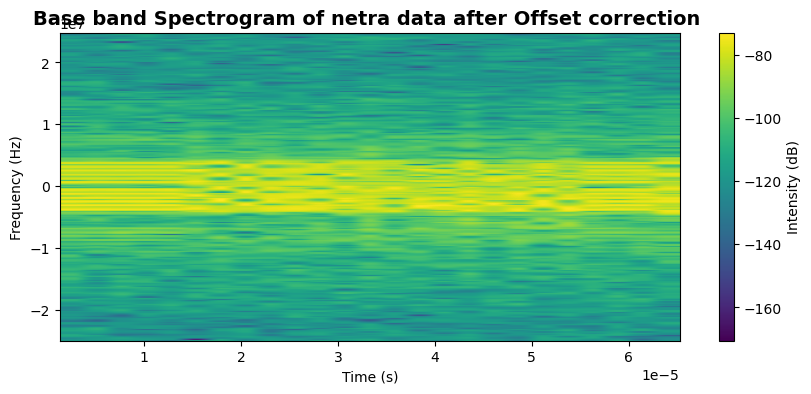

In [7]:
# Compute and plot spectrogram for the original data
plt.figure(figsize=(10, 4))
plt.specgram(data, Fs=fs)
plt.title('Base band Spectrogram of netra data after Offset correction ', fontsize=14, fontweight='bold')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Intensity (dB)")
plt.show()


# Power spectral density of netra data after offset frequency correction

/tmp/ipykernel_14973/2584206678.py:13: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = hamming(len(data))


Mean PSD Value: 8.20e-10 V^2/Hz


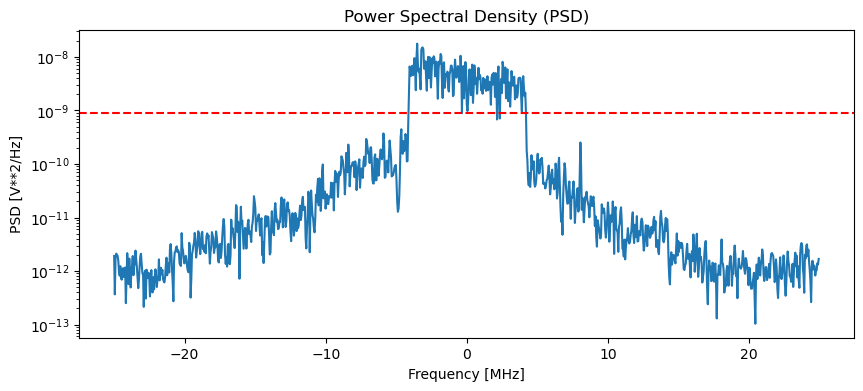

In [8]:
from scipy.signal import welch
# Parameters
fs = 50e6  # Sampling frequency (50 MHz)
nfft_welch = 1024  # Number of FFT points for Welch's method



# Ensure data length is sufficient for Welch's method
if len(data) < nfft_welch:
    print("Insufficient data length for Welch's method")
else:
    # Apply Hamming window
    window = hamming(len(data))
    data_windowed = data * window

    # Calculate PSD using Welch's method
    f, Pxx_den = welch(
        data_windowed, fs=fs, nperseg=nfft_welch, return_onesided=False
    )

    # Shift frequency and PSD for negative frequencies
    Pxx_den_shifted_data = np.fft.fftshift(Pxx_den)
    f_shifted_data = np.fft.fftshift(f)

     # Calculate the mean PSD value
    mean_psd_value = np.mean(Pxx_den_shifted_data)
    print(f"Mean PSD Value: {mean_psd_value:.2e} V^2/Hz")

    
    # Plot the PSD
    plt.figure(figsize=(10, 4))
    plt.semilogy(f_shifted_data / 1e6, Pxx_den_shifted_data)  # Convert frequency to MHz
    plt.axhline(1.1 * Pxx_den_shifted_data.mean(), color='r', linestyle='--', label="Mean PSD")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD [V**2/Hz]")
    plt.title("Power Spectral Density (PSD)")
    
    plt.show()


# Frequency spectrum of netra data after offset frequency correction

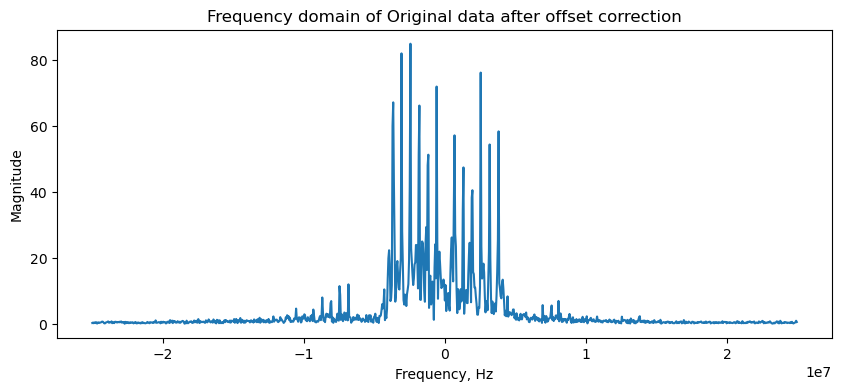

In [10]:
# Set fft size
N_fft = 1024

# calculate fft
data_fft = np.fft.fftshift(np.fft.fft(data, N_fft))
freqs = np.fft.fftshift(np.fft.fftfreq(N_fft,1/fs))


plt.figure(figsize=(10, 4))
plt.plot(freqs, np.abs(data_fft))

plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')
plt.title('Frequency domain of Original data after offset correction')
plt.show()


# Magnitude and phase response of netra data after offset frequency correction

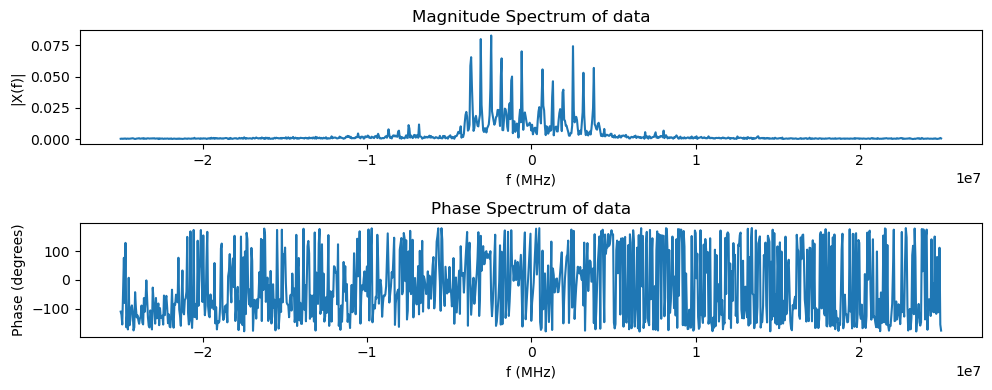

In [12]:
# Parameters
N = 1024  # FFT size
fs = 50e6  # Sampling frequency
x = data  # Your time-domain signal data

# Compute the FFT
X = np.fft.fftshift(np.fft.fft(x, N)) / N  # N-point complex DFT with fftshift

# Frequency axis
df = fs / N  # Frequency resolution
sampleIndex = np.arange(-N // 2, N // 2)  # Ordered index for FFT plot
f = sampleIndex * df  # X-axis in Hz

# Magnitude plot
plt.figure(figsize=(10, 4))

plt.subplot(2, 1, 1)
plt.plot(f, np.abs(X))  # Magnitude vs frequencies
plt.xlabel('f (MHz)')
plt.ylabel('|X(f)|')
plt.title('Magnitude Spectrum of data')

# Phase plot
phase = np.angle(X, deg=True)  # Phase in degrees
plt.subplot(2, 1, 2)
plt.plot(f, phase)  # Phase vs frequencies
plt.xlabel('f (MHz)')
plt.ylabel('Phase (degrees)')
plt.title('Phase Spectrum of data')

# Show the plots
plt.tight_layout()
plt.show()


# Applying Low pass filter on netra data after offset frequency

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


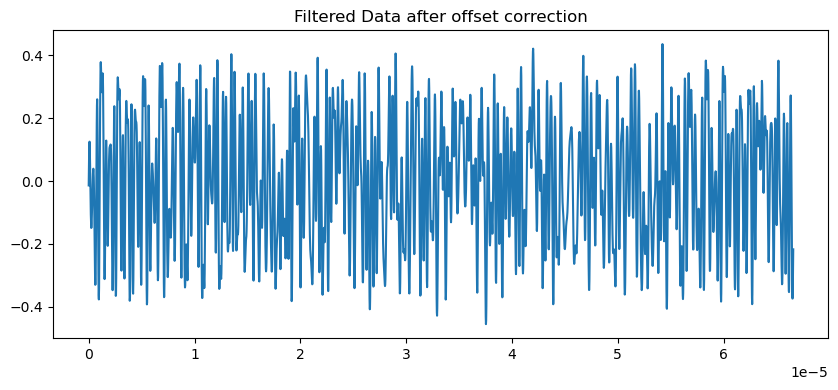

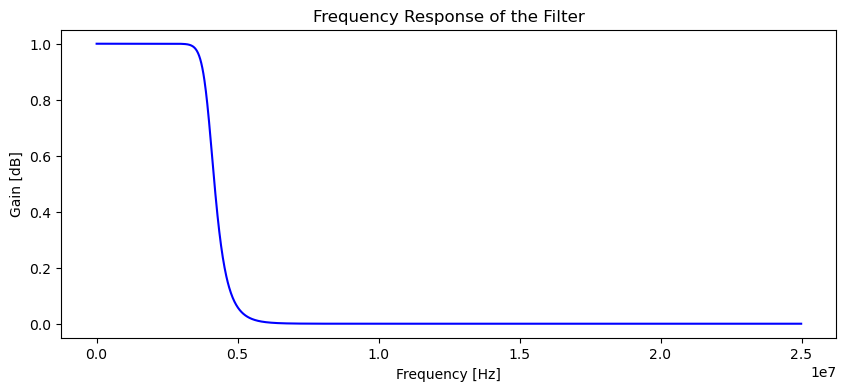

In [13]:
def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 12):
    # Design the low-pass filter using Butterworth filter
    sos = scipy.signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data, sos

# Apply a 4 MHz low-pass filter to the original data
filtered_data, sos = lowpass(data, 4e6, fs)

# Frequency response of the filter
w, h = scipy.signal.sosfreqz(sos, worN=2000, fs=fs)


# Plot the filtered signal
plt.figure(figsize=(10, 4))
plt.plot(time, filtered_data)
plt.title("Filtered Data after offset correction")
#plt.grid(alpha=.5, ls='--')
plt.show()

# Plot the frequency response of the filter
plt.figure(figsize=(10, 4))
plt.plot(w, np.abs(h), 'b')
plt.title("Frequency Response of the Filter")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
#plt.grid(alpha=.5, ls='--')
plt.show()


# Spectrogram visualization of filtered data

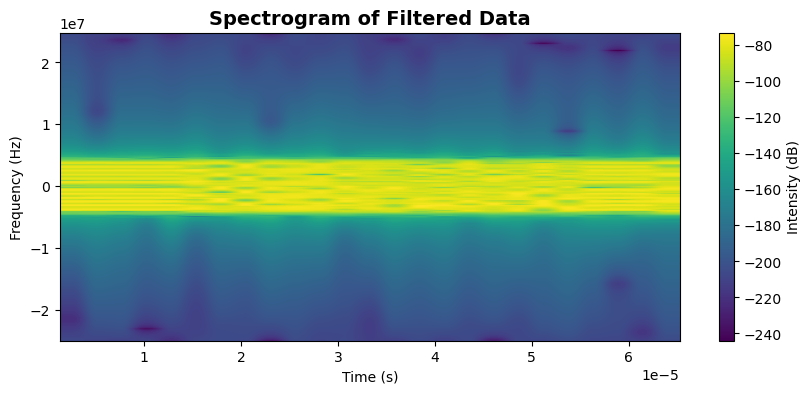

In [14]:
# Compute and plot spectrogram for the filtered data
plt.figure(figsize=(10, 4))
plt.specgram(filtered_data, Fs=fs)
plt.title('Spectrogram of Filtered Data', fontsize=14, fontweight='bold')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Intensity (dB)")
plt.show()

# Frequency spectrum of filtered data

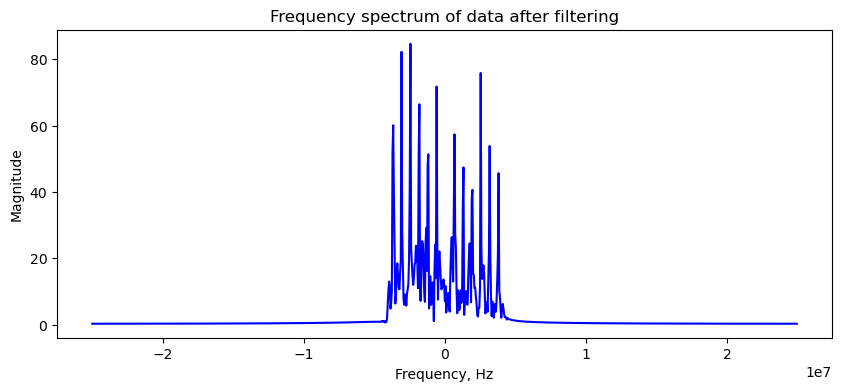

In [15]:
# calculate fft for filtered data
filtered_data_fft = np.fft.fftshift(np.fft.fft(filtered_data, N_fft))
freqs = np.fft.fftshift(np.fft.fftfreq(N_fft,1/fs))


plt.figure(figsize=(10, 4))
plt.plot(freqs, np.abs(filtered_data_fft),color='blue')

plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum of data after filtering')
plt.show()

# PHASE & GROUP DELAY

/tmp/ipykernel_14973/3336474136.py:5: RuntimeWarning: invalid value encountered in divide
  phase_delay = -phase / w


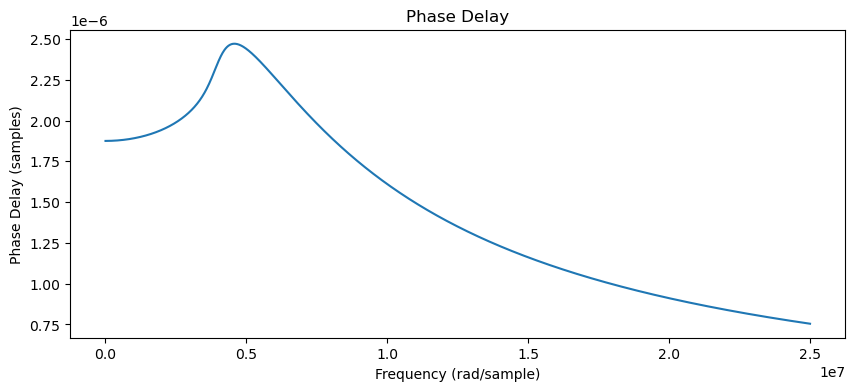

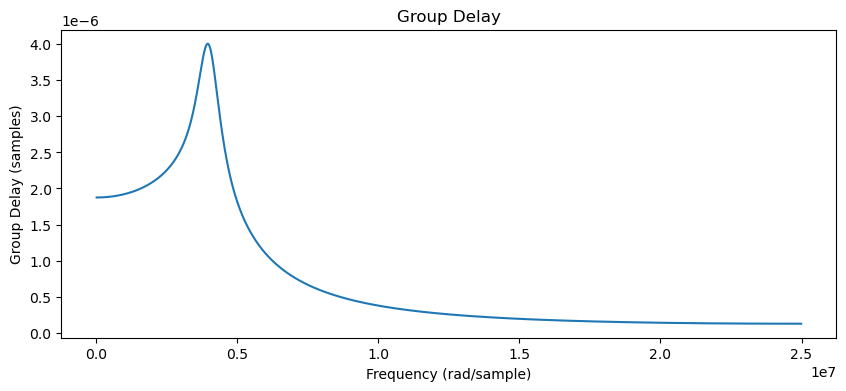

In [18]:
# Calculate phase response
phase = np.unwrap(np.angle(h))

# Calculate phase delay
phase_delay = -phase / w

# Calculate group delay
group_delay = -np.diff(phase) / np.diff(w)

# Plot the results
plt.figure(figsize=(10,4))
plt.plot(w, phase_delay)
plt.title('Phase Delay')
plt.xlabel('Frequency (rad/sample)')
plt.ylabel('Phase Delay (samples)')

plt.figure(figsize=(10,4))
plt.plot(w[1:], group_delay)
plt.title('Group Delay')
plt.xlabel('Frequency (rad/sample)')
plt.ylabel('Group Delay (samples)')

plt.show()

# Resampling of filtered data

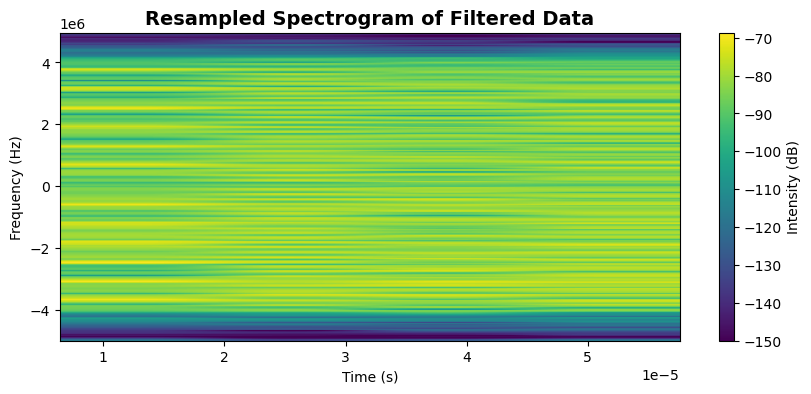

In [19]:
VMIN = -150

P = 50e6
Q = 10e6
plt.figure(figsize=(10,4))
plt.specgram(scipy.signal.resample(filtered_data, int(len(filtered_data)*Q/P)),
             scale='dB', Fs=Q, vmin=VMIN)
plt.title('Resampled Spectrogram of Filtered Data', fontsize=14, fontweight='bold')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Intensity (dB)")
plt.show()


# SNR calculation for filtered data

In [31]:
def calculate_snr(original_signal, filtered_signal):
    # Calculate signal power (mean squared of filtered signal)
    signal_power = np.mean(np.abs(filtered_signal) ** 2)

    # Calculate noise power (difference between original and filtered signal)
    noise_power = np.mean((np.abs(original_signal - filtered_signal)) ** 2)

    # Calculate SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Example usage
snr_value = calculate_snr(data, filtered_data)
print(f"SNR of filtered data: {snr_value:.2f} dB")


SNR of filtered data: 16.76 dB


# Power spectral density for filtered data

Mean PSD Value: 7.49e-10 V^2/Hz


/tmp/ipykernel_14973/2232393361.py:6: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = hamming(len(filtered_data))


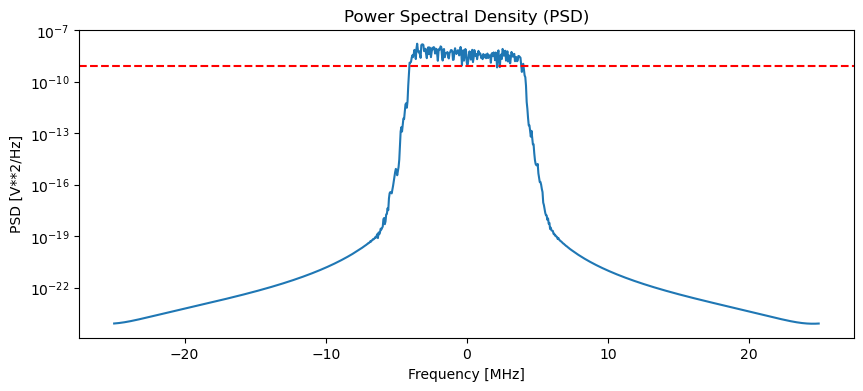

In [20]:
# Ensure data length is sufficient for Welch's method
if len(filtered_data) < nfft_welch:
    print("Insufficient data length for Welch's method")
else:
    # Apply Hamming window
    window = hamming(len(filtered_data))
    filtered_data_windowed = filtered_data * window

    # Calculate PSD using Welch's method
    f, Pxx_den = welch(
        filtered_data_windowed, fs=fs, nperseg=nfft_welch, return_onesided=False
    )

    # Shift frequency and PSD for negative frequencies
    Pxx_den_shifted = np.fft.fftshift(Pxx_den)
    f_shifted = np.fft.fftshift(f)

     # Calculate the mean PSD value
    filtered_mean_psd_value = np.mean(Pxx_den_shifted)
    print(f"Mean PSD Value: {filtered_mean_psd_value:.2e} V^2/Hz")

    
    # Plot the PSD
    plt.figure(figsize=(10, 4))
    plt.semilogy(f_shifted / 1e6, Pxx_den_shifted)  # Convert frequency to MHz
    plt.axhline(1.1 * Pxx_den_shifted.mean(), color='r', linestyle='--', label="Mean PSD")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD [V**2/Hz]")
    plt.title("Power Spectral Density (PSD)")
    
    plt.show()


# Magnitude and phase response of filtered data

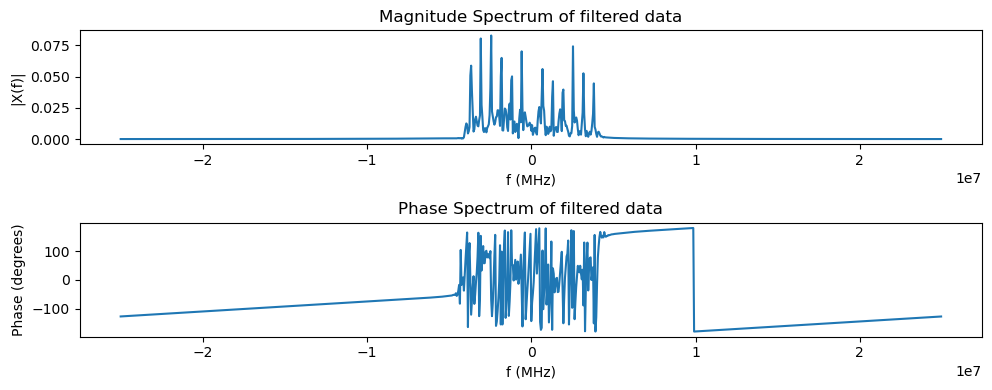

In [22]:
x = filtered_data  # Your time-domain signal data

# Compute the FFT
X = np.fft.fftshift(np.fft.fft(x, N)) / N  # N-point complex DFT with fftshift

# Frequency axis
df = fs / N  # Frequency resolution
sampleIndex = np.arange(-N // 2, N // 2)  # Ordered index for FFT plot
f = sampleIndex * df  # X-axis in Hz

# Magnitude plot
plt.figure(figsize=(10, 4))

plt.subplot(2, 1, 1)
plt.plot(f, np.abs(X))  # Magnitude vs frequencies
plt.xlabel('f (MHz)')
plt.ylabel('|X(f)|')
plt.title('Magnitude Spectrum of filtered data')

# Phase plot
phase = np.angle(X, deg=True)  # Phase in degrees
plt.subplot(2, 1, 2)
plt.plot(f, phase)  # Phase vs frequencies
plt.xlabel('f (MHz)')
plt.ylabel('Phase (degrees)')
plt.title('Phase Spectrum of filtered data' )

# Show the plots
plt.tight_layout()
plt.show()


# Feature extraction 

# Time domain and frequency domain feature extraction from filtered data

In [47]:
FEATURES = ['MIN', 'MAX', 'MEAN', 'RMS', 'VAR', 'STD', 'POWER', 'PEAK', 'P2P', 'CREST FACTOR', 
            'SKEW', 'KURTOSIS', 'MAX_f', 'SUM_f', 'MEAN_f', 'VAR_f', 'PEAK_f', 'SKEW_f', 'KURTOSIS_f']

def features_extraction(df): 
    # Initialize feature lists
    Min = []; Max = []; Mean = []; Rms = []; Var = []; Std = []; Power = []; Peak = []; Skew = []; Kurtosis = []; 
    P2p = []; CrestFactor = []; FormFactor = []; PulseIndicator = [];
    Max_f = []; Sum_f = []; Mean_f = []; Var_f = []; Peak_f = []; Skew_f = []; Kurtosis_f = [];
    
    # Extract data directly from df (assuming df is a series or array-like object containing the signal)
    X = df.values  # Directly use the values from the dataframe
    
    ## TIME DOMAIN ##
    Min.append(np.min(X))
    Max.append(np.max(X))
    Mean.append(np.mean(X))
    Rms.append(np.sqrt(np.mean(X**2)))
    Var.append(np.var(X))
    Std.append(np.std(X))
    Power.append(np.mean(X**2))
    Peak.append(np.max(np.abs(X)))
    P2p.append(np.ptp(X))  # Peak-to-Peak
    CrestFactor.append(np.max(np.abs(X)) / np.sqrt(np.mean(X**2)))
    Skew.append(stats.skew(X))
    Kurtosis.append(stats.kurtosis(X))
    FormFactor.append(np.sqrt(np.mean(X**2)) / np.mean(X))  # Form Factor
    PulseIndicator.append(np.max(np.abs(X)) / np.mean(X))  # Pulse Indicator
    
    ## FREQ DOMAIN ##
    ft = fft(X)  # Fourier transform of the signal
    S = np.abs(ft)**2 / len(X)  # Power spectral density (normalized)
    
    Max_f.append(np.max(S))
    Sum_f.append(np.sum(S))
    Mean_f.append(np.mean(S))
    Var_f.append(np.var(S))
    Peak_f.append(np.max(np.abs(S)))
    Skew_f.append(stats.skew(S))
    Kurtosis_f.append(stats.kurtosis(S))
    
    # Print each feature individually
    print("# TIME DOMAIN")
    print(f"Minimum amplitude of the signal: {Min[0]}")
    print(f"Maximum amplitude of the signal: {Max[0]}")
    print(f"Mean or Average Value of signal: {Mean[0]}")
    print(f"Root mean square of the signal: {Rms[0]}")
    print(f"Variance of the signal's amplitude: {Var[0]}")
    print(f"Standard Deviation of the signal's amplitude: {Std[0]}")
    print(f"Average power of the signal: {Power[0]}")
    print(f"Peak amplitude of the signal: {Peak[0]}")
    print(f"Peak-to-Peak amplitude of the signal: {P2p[0]}")
    print(f"Crest factor of the signal: {CrestFactor[0]}")
    print(f"Skewness of the signal's amplitude distribution: {Skew[0]}")
    print(f"Kurtosis of the signal's amplitude distribution: {Kurtosis[0]}")

    print("# FREQUENCY DOMAIN")
    print(f"Maximum frequency component power: {Max_f[0]}")
    print(f"Total power in the frequency spectrum: {Sum_f[0]}")
    print(f"Average power in the frequency spectrum: {Mean_f[0]}")
    print(f"Frequency domain variance: {Var_f[0]}")
    print(f"Peak value of the frequency spectrum.: {Peak_f[0]}")
    print(f"Skewness of the frequency spectrum: {Skew_f[0]}")
    print(f"Kurtosis of the frequency spectrum: {Kurtosis_f[0]}")

# Example usage with signal data directly in df
 # Example signal data (replace with your actual signal data)
df = pd.DataFrame(np.abs(filtered_data))  # Convert to DataFrame if needed

# Extract and print features
features_extraction(df)


# TIME DOMAIN
Minimum amplitude of the signal: 0.006246381454292752
Maximum amplitude of the signal: 0.4815151091664386
Mean or Average Value of signal: 0.2752526970131824
Root mean square of the signal: 0.28969078353183964
Variance of the signal's amplitude: 0.008156702850260392
Standard Deviation of the signal's amplitude: 0.09031446645062126
Average power of the signal: 0.08392075006329117
Peak amplitude of the signal: 0.4815151091664386
Peak-to-Peak amplitude of the signal: 0.47526872771214584
Crest factor of the signal: 1.6621692388550418
Skewness of the signal's amplitude distribution: [-0.41501014]
Kurtosis of the signal's amplitude distribution: [-0.45074605]
# FREQUENCY DOMAIN
Maximum frequency component power: 6.962666677344363e-05
Total power in the frequency spectrum: 0.08392075006329118
Average power in the frequency spectrum: 2.5201426445432787e-05
Frequency domain variance: 2.0186020547612053e-10
Peak value of the frequency spectrum.: 6.962666677344363e-05
Skewness of th

# Amplitude envelope of filtered data

/home/sandeep/.local/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


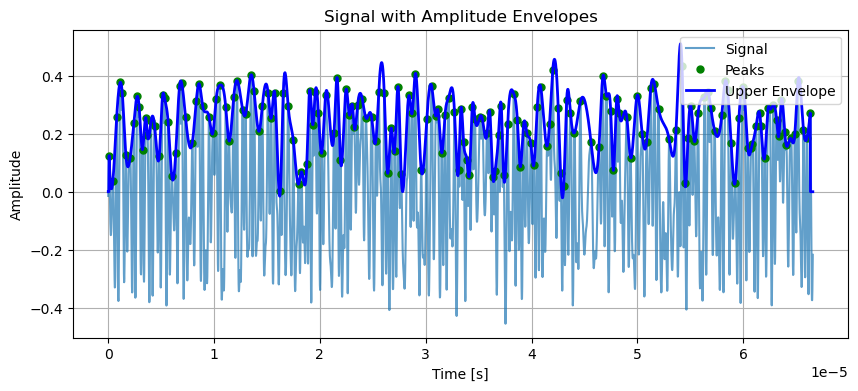

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

class EnvelopeDetector:
    def __init__(self, signal, sample_rate):
        self.signal = signal
        self.sample_rate = sample_rate

    def Inverse_Fourrier_transform(self):
        """
        Assuming the signal is in the frequency domain, this method would return
        the signal in the time domain. For now, it's just returning the original signal
        if the data is already in the time domain.
        """
        # For now, returning the original signal (if already in time domain)
        return self.signal

    def Get_envelope(self):
        """
        Calculates the envelope of the interpolated data (upper and lower envelopes).
        """
        # Apply the inverse Fourier transform (if needed)
        x_long = self.Inverse_Fourrier_transform()
        
        # Find peaks and troughs (local maxima and minima)
        peaks, _ = find_peaks(x_long.squeeze(), height=0)  # Peaks (local maxima)
        troughs, _ = find_peaks(-x_long.squeeze())         # Troughs (local minima)
        
        # Interpolation using cubic splines for upper and lower envelopes
        u_p = interp1d(peaks, x_long.squeeze()[peaks], kind='cubic', bounds_error=False, fill_value=0.0)
        l_p = interp1d(troughs, x_long.squeeze()[troughs], kind='cubic', bounds_error=False, fill_value=0.0)
        
        # Compute the upper and lower envelopes
        Upper_envelope = [u_p(i) for i in range(x_long.shape[0])]
        Lower_envelope = [l_p(i) for i in range(x_long.shape[0])]
        
        return peaks, troughs, Upper_envelope, Lower_envelope

# Example: Assuming 'data' is already your signal loaded from a file or other source
# For example, data could be loaded like this:
# data = np.fromfile("/path/to/your/datafile.dat", dtype=np.float32)

sample_rate = 50e6  # Example: 50 MHz sampling rate (replace with your actual sampling rate)
# Make sure 'data' is loaded into the 'data' variable.

# Initialize the EnvelopeDetector object
detector = EnvelopeDetector(filtered_data, sample_rate)

# Get the envelope (peaks, troughs, and envelopes)
peaks, troughs, Upper_envelope, Lower_envelope = detector.Get_envelope()

# Generate time axis for plotting (replace with actual time based on your signal and sample rate)
time = np.arange(0, len(filtered_data)) / sample_rate

# Plot the signal and its amplitude envelopes
plt.figure(figsize=(10, 4))
plt.plot(time, filtered_data, label='Signal', alpha=0.7)
plt.plot(time[peaks], filtered_data[peaks], 'go', label='Peaks', markersize=5)  # Peaks in green
#plt.plot(time[troughs], data[troughs], 'ro', label='Troughs', markersize=5)  # Troughs in red
plt.plot(time, Upper_envelope, color='blue', label='Upper Envelope', linewidth=2)
#plt.plot(time, Lower_envelope, color='orange', label='Lower Envelope', linewidth=2)

# Set plot labels and title
plt.title("Signal with Amplitude Envelopes")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Skewness and Kurtosis of filtered data

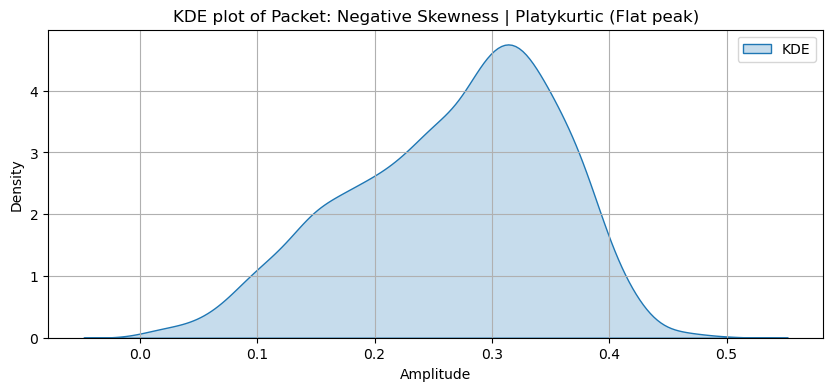

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate skewness
def moment_based_skew(distribution):
    n = len(distribution)
    mean = np.mean(distribution)
    std = np.std(distribution)

    # Divide the formula into two parts
    first_part = n / ((n - 1) * (n - 2))
    second_part = np.sum(((distribution - mean) / std) ** 3)

    skewness = first_part * second_part
    return skewness

# Function to calculate kurtosis
def moment_based_kurtosis(distribution):
    n = len(distribution)
    mean = np.mean(distribution)
    std = np.std(distribution)

    kurtosis = (1 / n) * np.sum(((distribution - mean) / std) ** 4) - 3
    return kurtosis



# Compute skewness and kurtosis
skewness = moment_based_skew(np.abs(filtered_data))
kurtosis_value = moment_based_kurtosis(np.abs(filtered_data))

# Determine skewness type
if skewness > 0:
    skewness_description = "Positive Skewness"
elif skewness < 0:
    skewness_description = "Negative Skewness"
else:
    skewness_description = "Symmetrical Distribution"

# Determine kurtosis type
if kurtosis_value > 3:
    kurtosis_description = "Leptokurtic (Sharp peak)"
elif kurtosis_value < 3:
    kurtosis_description = "Platykurtic (Flat peak)"
else:
    kurtosis_description = "Mesokurtic (Normal peak)"

# Plot the KDE for the current packet
plt.figure(figsize=(10, 4))

# Use the magnitude for KDE plotting
sns.kdeplot(np.abs(filtered_data), label="KDE", fill=True)  # KDE for magnitude
plt.title(f"KDE plot of Packet: {skewness_description} | {kurtosis_description}")
plt.xlabel("Amplitude")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
